## 목표변수를 제외한 모든 변수를 가지고 결정트리 생성

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.tree import export_graphviz
import graphviz
from matplotlib import pyplot as plt 

In [3]:
from sklearn.model_selection import GridSearchCV

In [4]:
def make_confusion(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion,columns=['Predicted_Negative','Predicted_Positive'],index=['Actual_Negative','Actual_Positive'])
    
    return confusion_df

In [5]:
df = pd.read_csv('../Data/Churn_Modelling_one_hot.csv')

In [6]:
df

,CustomerId,CreditScore,Geography_Category1,Geography_Category2,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,0,0,0,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,1,0,0,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,0,0,0,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,0,0,0,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,1,0,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,771,0,0,1,39,5,0.00,2,1,0,96270.64,0
9996,15569892,516,0,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,709,0,0,0,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,0,1,1,42,3,75075.31,2,1,0,92888.52,1


### 목표변수 설정 작업

In [7]:
x = df[['CreditScore','Geography_Category1','Geography_Category2','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

In [8]:
y = df['Exited']

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=12)

In [10]:
dt_clf = DecisionTreeClassifier(random_state = 15)

### 결정트리에 적합

In [11]:
dt_clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=15)

In [12]:
y_predict = dt_clf.predict(x_test)

### 오차행렬 생성

In [13]:
confusion_df = make_confusion(y_test, y_predict)
confusion_df

,Predicted_Negative,Predicted_Positive
Actual_Negative,2053,301
Actual_Positive,306,340


In [14]:
accuracy = accuracy_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
print('결정트리 예측 정확도:{0:.4f}'.format(accuracy))
print('결정트리 예측 민감도:{0:.4f}'.format(recall))
print('결정트리 예측 특이도:{0:.4f}'.format(confusion_df.iloc[0,0]/(confusion_df.iloc[0,0]+confusion_df.iloc[0,1])))

결정트리 예측 정확도:0.7977
결정트리 예측 민감도:0.5263
결정트리 예측 특이도:0.8721


In [15]:
feature_name = x.columns
feature_importances = dt_clf.feature_importances_
sorted(zip(feature_importances,feature_name),reverse = True)

[(0.2477034876408354, 'Age'),
 (0.1660726888439777, 'EstimatedSalary'),
 (0.14667849787562742, 'Balance'),
 (0.13594256160343174, 'CreditScore'),
 (0.11632374675926156, 'NumOfProducts'),
 (0.06938587323546536, 'Tenure'),
 (0.051179783727671575, 'IsActiveMember'),
 (0.025259749198462637, 'Geography_Category2'),
 (0.016376924977437805, 'Gender'),
 (0.014422887840253869, 'HasCrCard'),
 (0.01065379829757487, 'Geography_Category1')]

In [16]:
export_graphviz(dt_clf, out_file = 'tree(full).dot',class_names = ['NotExited','Exited'],feature_names = feature_name,impurity=True,filled=True)

In [17]:
with open('tree(full).dot',encoding='utf-8') as f:
    dot_graph1 = f.read()
graph = graphviz.Source(dot_graph1)

In [18]:
graph.format='png'
graph.render('dt(full)')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.620811 to fit


'dt(full).png'

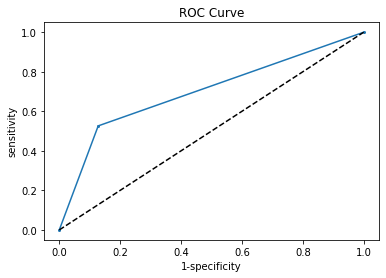

In [19]:
fpr1, tpr1, threshold1 = roc_curve(y_test, dt_clf.predict_proba(x_test)[:,1])
plt.plot(fpr1,tpr1,'o-',ms=2,label = 'ROC')
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.title('ROC Curve')
plt.savefig('Full ROC.png',bbox_inches='tight')
plt.show()

================================================================================================================================================================================

## GridSearchCV를 통해 최적 하이퍼 파라미터 튜닝

### 파라미터 튜닝

In [20]:
params = {
    'max_depth': [6,8,10,12,16,20,24],
    'min_samples_split':[8,12,16,20,24,28,32]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose =1 )

In [21]:
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.8594
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 6, 'min_samples_split': 16}


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:    5.3s finished


### 튜닝한 파라미터로 모델 생성후 적합

In [22]:
dt_clf = DecisionTreeClassifier(random_state = 15, max_depth=6, min_samples_split=16)

In [23]:
dt_clf.fit(x_train,y_train)
y_pred = dt_clf.predict(x_test)

In [24]:
export_graphviz(dt_clf, out_file = 'tree(depth6).dot',class_names = ['NotExited','Exited'],feature_names = feature_name,impurity=True,filled=True)

In [25]:
with open('tree(depth6).dot',encoding='utf-8') as f:
    dot_graph2 = f.read()
graph = graphviz.Source(dot_graph2)

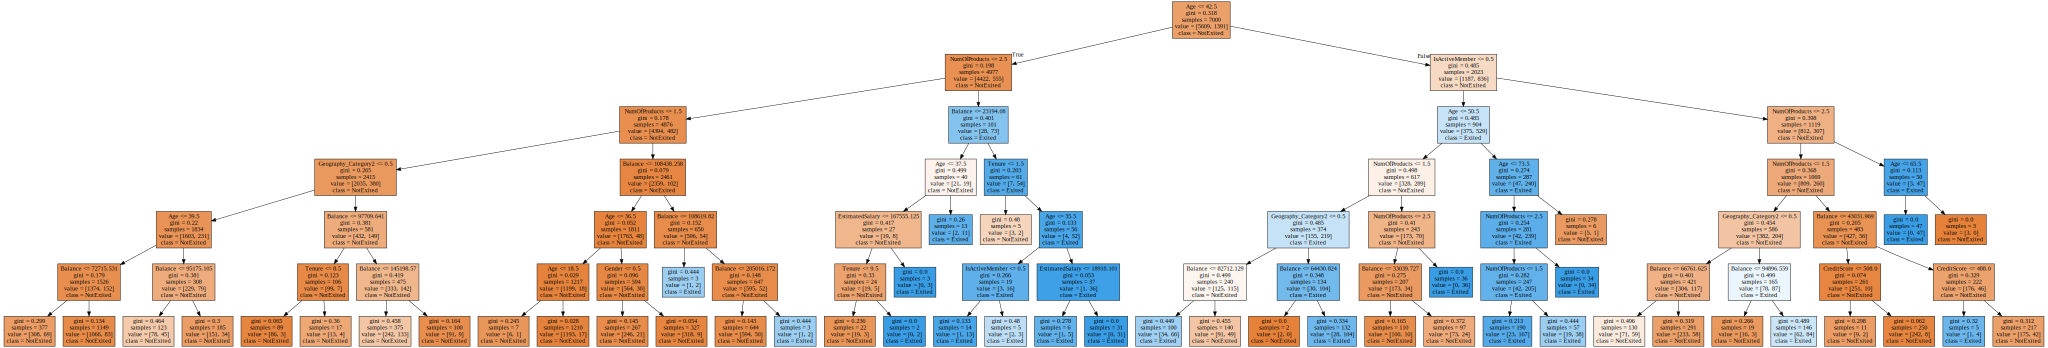

In [26]:
graph

In [27]:
graph.format='png'
graph.render('dt(depth6)')

'dt(depth6).png'

In [28]:
feature_name = x.columns
feature_importances = dt_clf.feature_importances_
sorted(zip(feature_importances,feature_name),reverse = True)

[(0.40645575153716945, 'Age'),
 (0.30492162632870584, 'NumOfProducts'),
 (0.11455143479232843, 'IsActiveMember'),
 (0.10368818989626309, 'Balance'),
 (0.052840563822874394, 'Geography_Category2'),
 (0.007596155050807491, 'Tenure'),
 (0.004783604504624385, 'CreditScore'),
 (0.004259007472967805, 'EstimatedSalary'),
 (0.0009036665942592697, 'Gender'),
 (0.0, 'HasCrCard'),
 (0.0, 'Geography_Category1')]

### 오차행렬 생성

In [29]:
confusion_df = make_confusion(y_test, y_pred)
confusion_df

,Predicted_Negative,Predicted_Positive
Actual_Negative,2278,76
Actual_Positive,358,288


In [30]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('결정트리 예측 정확도:{0:.4f}'.format(accuracy))
print('결정트리 예측 민감도:{0:.4f}'.format(recall))
print('결정트리 예측 특이도:{0:.4f}'.format(confusion_df.iloc[0,0]/(confusion_df.iloc[0,0]+confusion_df.iloc[0,1])))

결정트리 예측 정확도:0.8553
결정트리 예측 민감도:0.4458
결정트리 예측 특이도:0.9677


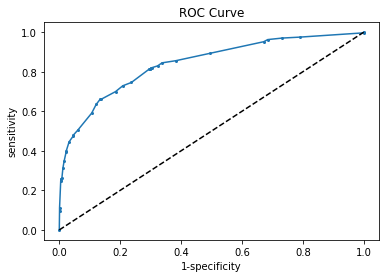

In [31]:
fpr2, tpr2, threshold2 = roc_curve(y_test, dt_clf.predict_proba(x_test)[:,1])
plt.plot(fpr2,tpr2,'o-',ms=2,label = 'ROC')
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.title('ROC Curve')
plt.savefig('depth6 ROC.png',bbox_inches='tight')
plt.show()

### 변수 중요도 파악

In [32]:
best_df_clf = grid_cv.best_estimator_

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게하고, 시본의 막대그래프로 수ㅢㅂ게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_importances = ftr_importances.sort_values(ascending=False) 

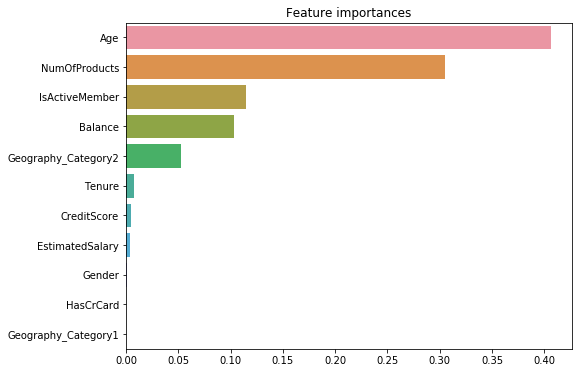

In [35]:
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x = ftr_importances, y = ftr_importances.index)
plt.savefig('full feature.png',bbox_inches='tight')
plt.show()

#### 변수 중요도가 한 국가가 영향을 끼치는것같아 하고자 하는 프로젝트의 취지에 어긋나는것으로 판단하여 제외함

=======================================================================================================================================================================================

## 변수 제한(국가 제외)

### 목표변수 설정

In [36]:
x = df[['CreditScore','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]
y = df['Exited']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=12)

In [38]:
dt_clf = DecisionTreeClassifier(random_state = 15)

In [39]:
dt_clf.fit(x_train,y_train)
y_pred = dt_clf.predict(x_test)

In [40]:
feature_name = x.columns
feature_importances = dt_clf.feature_importances_
sorted(zip(feature_importances,feature_name),reverse = True)

[(0.24846357094646188, 'Age'),
 (0.16036002386876422, 'CreditScore'),
 (0.15662674446965982, 'Balance'),
 (0.1541545803809402, 'EstimatedSalary'),
 (0.11632374675926153, 'NumOfProducts'),
 (0.07936764151052743, 'Tenure'),
 (0.054958873111716, 'IsActiveMember'),
 (0.015105656938207698, 'Gender'),
 (0.014639162014461174, 'HasCrCard')]

In [41]:
params = {
    'max_depth': [6,8,10,12,16,20,24],
    'min_samples_split':[8,12,16,20,24,28,32]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose =1 )

In [42]:
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GridSearchCV 최고 평균 정확도 수치: 0.8550
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 6, 'min_samples_split': 16}


[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:    5.1s finished


In [43]:
dt_clf = DecisionTreeClassifier(random_state = 15, max_depth=6, min_samples_split=16)

In [44]:
dt_clf.fit(x_train,y_train)
y_prediction = dt_clf.predict(x_test)

### 오차행렬 생성

In [45]:
confusion_df = make_confusion(y_test, y_prediction)
confusion_df

,Predicted_Negative,Predicted_Positive
Actual_Negative,2225,129
Actual_Positive,347,299


In [46]:
accuracy = accuracy_score(y_test, y_prediction)
recall = recall_score(y_test, y_prediction)
print('결정트리 예측 정확도:{0:.4f}'.format(accuracy))
print('결정트리 예측 민감도:{0:.4f}'.format(recall))
print('결정트리 예측 특이도:{0:.4f}'.format(confusion_df.iloc[0,0]/(confusion_df.iloc[0,0]+confusion_df.iloc[0,1])))

결정트리 예측 정확도:0.8413
결정트리 예측 민감도:0.4628
결정트리 예측 특이도:0.9452


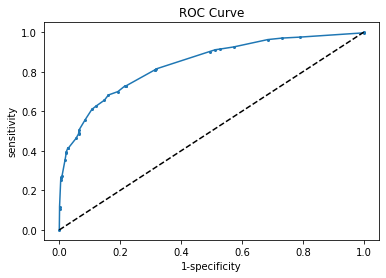

In [47]:
fpr3, tpr3, threshold3 = roc_curve(y_test, dt_clf.predict_proba(x_test)[:,1])
plt.plot(fpr3,tpr3,'o-',ms=2,label = 'ROC')
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.title('ROC Curve')
plt.savefig('No country ROC.png',bbox_inches='tight')
plt.show()

In [48]:
export_graphviz(dt_clf, out_file = 'tree(feature_limited).dot',class_names = ['NotExited','Exited'],feature_names = feature_name,impurity=True,filled=True)

In [49]:
with open('tree(feature_limited).dot',encoding='utf-8') as f:
    dot_graph3 = f.read()
graph = graphviz.Source(dot_graph3)

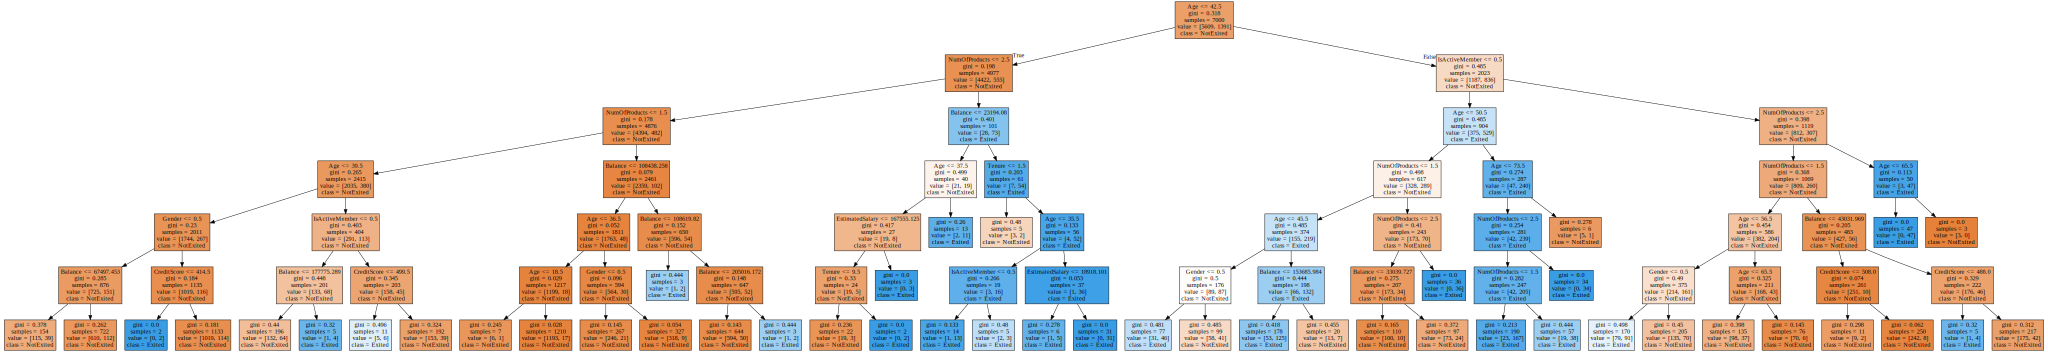

In [50]:
graph

In [51]:
graph.format='png'
graph.render('limited_dt')

'limited_dt.png'

In [52]:
feature_name = x.columns
feature_importances = dt_clf.feature_importances_
sorted(zip(feature_importances,feature_name),reverse = True)

[(0.46434767103512775, 'Age'),
 (0.32495603858540506, 'NumOfProducts'),
 (0.12552135932428873, 'IsActiveMember'),
 (0.04233168519682442, 'Balance'),
 (0.019461633550545903, 'Gender'),
 (0.012201297293234239, 'CreditScore'),
 (0.0066414759253802, 'Tenure'),
 (0.004538839089193732, 'EstimatedSalary'),
 (0.0, 'HasCrCard')]

In [53]:
best_df_clf = grid_cv.best_estimator_
ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게하고, 시본의 막대그래프로 수ㅢㅂ게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_importances = ftr_importances.sort_values(ascending=False) 

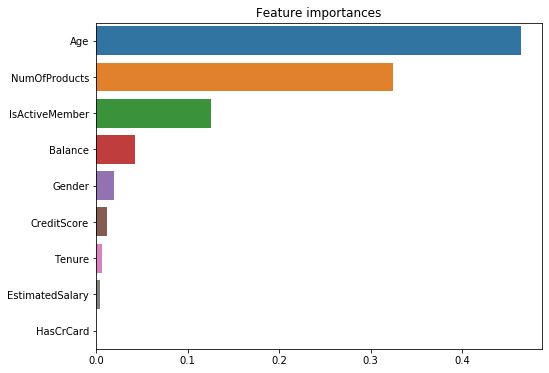

In [54]:
plt.figure(figsize=(8,6))
plt.title('Feature importances')
sns.barplot(x = ftr_importances, y = ftr_importances.index)
plt.savefig('No Country feature.png',bbox_inches='tight')
plt.show()

#### 국가코드를 제외했더니 CreditScore와 EstimatedSalary가 눈에 띄게 점수가 높아졌음을 알 수 있음
#### 그리고 Balance의 중요도가 상대적으로 줄었음